# News Article Classification
Assignments from "Machine learning and text-as-data methods for economists".    
This notebook covers both the ML and the TADA parts.    
Solutions by: Paul Solbach (ps@audyem.com)

*Questions*:
I selected the BBC news corpus because it fits the problem domain of my dissertation, data work in digital news businesses.    
My response variable is the section classification of the corresponding news articles.
Among KNN, ridge and lasso, I expect KNN to dominate the estimators.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, cohen_kappa_score, confusion_matrix
from textblob import Word

In [2]:
import nltk
nltk.download('omw-1.4', quiet=True)

True

In [3]:
def clean_str(string):
    string = re.sub(r"\'s", "", string)
    string = re.sub(r"\'ve", "", string)
    string = re.sub(r"n\'t", "", string)
    string = re.sub(r"\'re", "", string)
    string = re.sub(r"\'d", "", string)
    string = re.sub(r"\'ll", "", string)
    string = re.sub(r",", "", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", "", string)
    string = re.sub(r"\)", "", string)
    string = re.sub(r"\?", "", string)
    string = re.sub(r"'", "", string)
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"[0-9]\w+|[0-9]","", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip().lower()

In [4]:
from sklearn.model_selection import train_test_split

## Data preparation
Transform the documents to bag of words and calculate the tf-idf matrix.    

In [5]:
data = pd.read_csv('./bbc-corpus/dataset.csv')
data.head()

,news,type
0,China had role in Yukos split-up\n \n China le...,business
1,Oil rebounds from weather effect\n \n Oil pric...,business
2,Indonesia 'declines debt freeze'\n \n Indonesi...,business
3,$1m payoff for former Shell boss\n \n Shell is...,business
4,US bank in $515m SEC settlement\n \n Five Bank...,business


In [6]:
x = data['news'].tolist()
y = data['type'].tolist()

for index,value in enumerate(x):
    x[index] = ' '.join([Word(word).lemmatize() for word in clean_str(value).split()])

In [7]:
x[0]

'china had role in yukos split up china lent russia to help the russian government renationalise the key yuganskneftegas unit of oil group yukos it ha been revealed the kremlin said on tuesday that the which russian state bank veb lent state owned rosneft to help buy yugansk in turn came from chinese bank the revelation came a the russian government said rosneft had signed a long term oil supply deal with china the deal see rosneft receive in credit from china cnpc according to russian newspaper vedomosti these credit would be used to pay off the loan rosneft received to finance the purchase of yugansk report said cnpc had been offered of yugansk in return for providing finance but the company opted for a long term oil supply deal instead analyst said one factor that might have influenced the chinese decision wa the possibility of litigation from yukos yugansk former owner if cnpc had become a shareholder rosneft and veb declined to comment the two company rosneft and cnpc have agreed 

In [8]:
vect = TfidfVectorizer(stop_words='english', min_df=2, max_features=5000)
X = vect.fit_transform(x)
Y = np.array(y)

print("Number of features extracted: ", X.shape[1])

Number of features extracted:  5000


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=123, shuffle=True)

In [10]:
print("Training set size: ", X_train.shape)
print("Testing set size: ", X_test.shape)

Training set size:  (1557, 5000)
Testing set size:  (668, 5000)


## Random Forest classifier

In [11]:
model = RandomForestClassifier(n_estimators=300, max_depth=150, n_jobs=8)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
c_mat = confusion_matrix(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)

print("Kappa: {:.4f}".format(kappa))
print("Accuracy: {:.4f}".format(acc))

Kappa: 0.9568
Accuracy: 0.9656


## Test prediction

Test classification of a random sample article from the corpus

In [12]:
def predict_section(fulltext):  # function to accept raw string and to provide news type(class)
    fulltext = [' '.join([Word(word).lemmatize() for word in clean_str(fulltext).split()])]
    features = vect.transform(fulltext)
    return str(model.predict(features)[0])

random_article = data.sample()
prediction = predict_section(fulltext=random_article.news.item())
print("\n{}! Article of section '{}' predicted as '{}'."
      .format(random_article.type.item() == prediction, random_article.type.item(), prediction))


True! Article of section 'entertainment' predicted as 'entertainment'.


## Support Vector Machine (SVM)
a model which generally seems to perform on the problem of news article classification.    
cf. https://www.stat.berkeley.edu/~aldous/Research/Ugrad/Nura_Kawa_report.pdf

In [13]:
from sklearn import svm

In [14]:
model = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
#model = svm.SVR(kernel="rbf", C=100, gamma=0.1, epsilon=0.1)
#model = svm.SVR(kernel="linear", C=100, gamma="auto")

model.fit(X_train, y_train)

y_pred_svm = model.predict(X_test)
c_mat = confusion_matrix(y_test, y_pred_svm)
kappa = cohen_kappa_score(y_test, y_pred_svm)
accuracy = accuracy_score(y_test, y_pred_svm)

print(f'Test set ccuracy: {accuracy: .2f}%')

Test set ccuracy:  0.98%


## K-nearest neighbor
Re-run the classifier with K-nearest neighbor

In [15]:
from sklearn.neighbors import KNeighborsClassifier

In [16]:
knn_model = KNeighborsClassifier(n_neighbors=15)
knn_model.fit(X_train, y_train)

y_pred_knn = knn_model.predict(X_test)

num_correct_predictions = (y_pred_knn == y_test).sum()
accuracy = (num_correct_predictions / y_test.shape[0]) * 100

print(f'Test set accuracy: {accuracy:.2f}%') # alternative formated print method

Test set accuracy: 95.06%


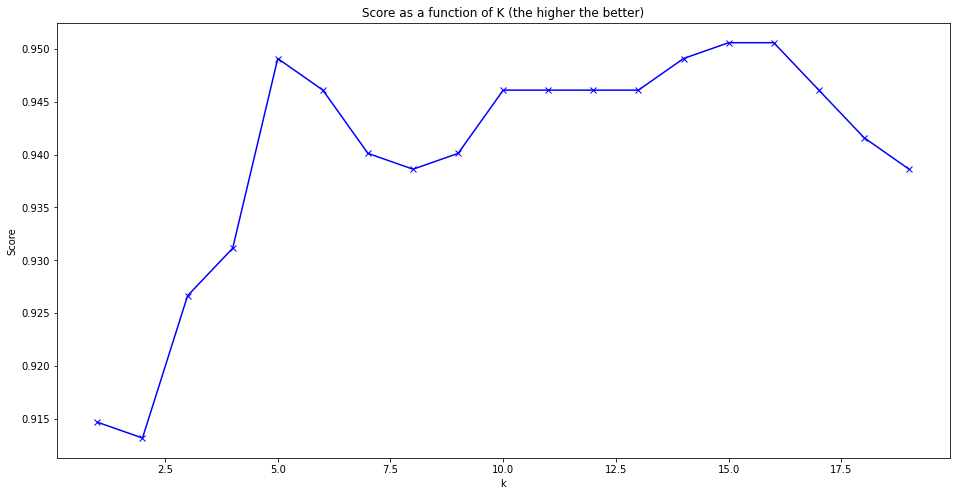

In [17]:
metric = []
K = range(1, 20)

for i in K:
  # Train the model using the training set only
  model = KNeighborsClassifier(n_neighbors=i)
  model.fit(X_train, y_train)

  # Compute some forecast evaluation score and append the scalar value
  metric.append(model.score(X_test, y_test))

plt.figure(figsize=(16,8))
plt.plot(K, metric, 'bx-')
plt.xlabel('k')
plt.ylabel('Score')
plt.title('Score as a function of K (the higher the better)')
plt.show()

Experimenting with `n_neighbors`, I found 15 to yield the best accuracy. Overall, KNN performed worse than SVM.

## Ridge Regression

In [18]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline

In [19]:
alphas = 10 ** np.linspace(10, -2, 100) * 0.5
alphas.shape
print(alphas[:10])

[5.00000000e+09 3.78231664e+09 2.86118383e+09 2.16438064e+09
 1.63727458e+09 1.23853818e+09 9.36908711e+08 7.08737081e+08
 5.36133611e+08 4.05565415e+08]


In [20]:
coefs = []

article_types = {
    'business': 0,
    'entertainment': 1,
    'politics': 2,
    'sport': 3,
    'tech': 4
}

article_numeric_types = {
    0: 'business',
    1: 'entertainment',
    2: 'politics',
    3: 'sport',
    4: 'tech'
}

y_train_numeric = [article_types[y] for y in y_train]
y_test_numeric = [article_types[y] for y in y_test]

model = Ridge()

for a in alphas:
    model.set_params(alpha=a)
    model.fit(X_train, y_train_numeric)
    coefs.append(model.coef_)
    
np.shape(coefs)

(100, 5000)

Text(0, 0.5, 'coefficients')

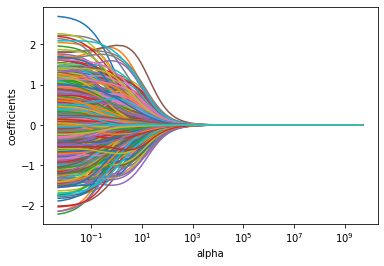

In [21]:
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('coefficients')

Compute the test error

In [22]:
metrics = np.zeros((alphas.shape[0], 2))  # 100 by 2 matrix

for idx, a in enumerate(alphas):
    model.set_params(alpha=a)
    model.fit(X_train, y_train_numeric)

    y_pred_ridge = model.predict(X_test)

    metrics[idx, 0] = a # store alpha value
    metrics[idx, 1] = mean_squared_error(y_test_numeric, y_pred_ridge) # store test error

In [23]:
print(metrics[:10,:])

[[5.00000000e+09 1.91304082e+00]
 [3.78231664e+09 1.91304082e+00]
 [2.86118383e+09 1.91304082e+00]
 [2.16438064e+09 1.91304081e+00]
 [1.63727458e+09 1.91304081e+00]
 [1.23853818e+09 1.91304080e+00]
 [9.36908711e+08 1.91304079e+00]
 [7.08737081e+08 1.91304077e+00]
 [5.36133611e+08 1.91304075e+00]
 [4.05565415e+08 1.91304073e+00]]


Text(0, 0.5, 'MSE')

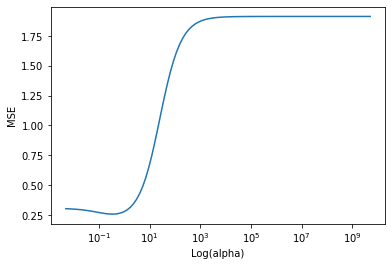

In [24]:
ax = plt.gca()
ax.plot(metrics[:,0], metrics[:,1])
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('Log(alpha)')
plt.ylabel('MSE')

In [25]:
idx = np.argmin(metrics[:,1])  # search for the minimum entry in the second column

AlphaMetric = {"alpha": metrics[idx,0], "metrics": metrics[idx,1]}
print(AlphaMetric)

{'alpha': 0.3289666123287841, 'metrics': 0.2572149454232997}


In [26]:
model = Ridge(alpha = AlphaMetric["alpha"])
model.fit(X_train, y_train_numeric)

print(f"The intercept is = {model.intercept_}\n")

y_pred_ridge_float = model.predict(X_test) # Use this model to predict the test data
y_pred_ridge = []

for y in y_pred_ridge_float:
    y_rounded_integer = min(4, max(0, round(float(y))))
    y_pred_ridge.append(y_rounded_integer)

accuracy = accuracy_score(y_test_numeric, y_pred_ridge)

print(mean_squared_error(y_test_numeric, y_pred_ridge)) # Calculate the test MSE
print(f"Estimated MSE = {mean_squared_error(y_test_numeric, y_pred_ridge)}.")
print("Expected MSE = {}.\n".format(AlphaMetric["metrics"]))
print(f'Test set accuracy: {accuracy:.2f}%') # alternative formated print method

The intercept is = 1.8391264182836646

0.27994011976047906
Estimated MSE = 0.27994011976047906.
Expected MSE = 0.2572149454232997.

Test set accuracy: 0.77%


In [27]:
random_article = data.sample()
prediction_float = predict_section(fulltext=random_article.news.item())
prediction_int = round(float(prediction_float))
prediction = article_numeric_types[prediction_int]

print("\n{}! Article of section '{}' predicted as '{}'."
      .format(random_article.type.item() == prediction, random_article.type.item(), prediction))


True! Article of section 'business' predicted as 'business'.


## Lasso Regression

In [32]:
from sklearn.linear_model import Lasso, LassoCV
from sklearn.preprocessing import scale
lasso = Lasso(max_iter = 10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(scale(X_train, with_mean=False), y_train_numeric)
    coefs.append(lasso.coef_)

In [33]:
y_pred_lasso_float = lasso.predict(X_test)
y_pred_lasso = []

for y in y_pred_lasso_float:
    y_rounded_integer = min(4, max(0, round(float(y))))
    y_pred_lasso.append(y_rounded_integer)

accuracy = accuracy_score(y_test_numeric, y_pred_lasso)

print(mean_squared_error(y_test_numeric, y_pred_lasso)) # Calculate the test MSE
print(f"Estimated MSE = {mean_squared_error(y_test_numeric, y_pred_lasso)}.")
print(f"Expected MSE = {AlphaMetric['metrics']}")
print(f"Test set accuracy: {accuracy:.2f}%")

1.9146706586826348
Estimated MSE = 1.9146706586826348.
Expected MSE = 0.2572149454232997
Test set accuracy: 0.20%


In [34]:
lassocv = LassoCV(alphas=None, cv=8, max_iter=5000)
lassocv.fit(X_train, y_train_numeric)

lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_train, y_train_numeric)

y_pred_lassocv_float = lasso.predict(X_test)
y_pred_lassocv = []

for y in y_pred_lassocv_float:
    y_rounded_integer = min(4, max(0, round(float(y))))
    y_pred_lassocv.append(y_rounded_integer)

accuracy = accuracy_score(y_test_numeric, y_pred_lassocv)

print(mean_squared_error(y_test_numeric, y_pred_lassocv)) # Calculate the test MSE
print(f"Estimated MSE = {mean_squared_error(y_test_numeric, y_pred_lassocv)}.")
print(f"Expected MSE = {AlphaMetric['metrics']}")
print(f"Test set accuracy: {accuracy:.2f}%")

0.3413173652694611
Estimated MSE = 0.3413173652694611.
Expected MSE = 0.2572149454232997
Test set accuracy: 0.73%
